# 集成学习(Ensemble Learning)
**姓名:** 独宇涵 **邮箱:** 231880151@smail.nju.edu.cn

**实验环境:** python 3.12.8

## 复现材料
实验过程中需要我们手动实现三种常见的集成学习算法（**Stacking**、**Bagging**、**AdaBoost**），下面是三种算法的代码实现
### Stacking
**输入:** 训练集 $D = \{(x_1, y_1), (x_2, y_2), \ldots, (x_m, y_m)\};$

初级学习算法 $\mathfrak{L}_1, \mathfrak{L}_2, \ldots, \mathfrak{L}_T;$

次级学习算法 $\mathfrak{L}.$

**过程：**
1. $\text{for } t = 1, 2, \ldots, T \text{ do}$
2. $h_t = \mathfrak{L}_t(D);$
3. $\text{end for}$
4. $D' = \emptyset;$
5. $\text{for } i = 1, 2, \ldots, m \text{ do}$
6. $\quad \text{for } t = 1, 2, \ldots, T \text{ do}$
7. $\quad z_{it} = h_t(x_i);$
8. $\quad \text{end for}$
9. $D' = D' \cup ((z_{i1}, z_{i2}, \ldots, z_{iT}), y_i);$
10. $\text{end for}$
11. $h' = \mathfrak{L}(D');$

**输出：**$H(x) = h'(h_1(x), h_2(x), \ldots, h_T(x))$

In [48]:
import numpy as np
from sklearn.model_selection import KFold
# 禁止输出警告
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2025)
def get_stacking(clf,x_train,y_train,x_test,n_folds = 10):
    # 核心是使用交叉验证算法得到次级训练集
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,))
    second_level_test_set = np.zeros((test_num,))
    test_nfolds_sets = np.zeros((test_num,n_folds))
    kf = KFold(n_splits = n_folds) #将数据进行折叠

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train[train_index], y_train[train_index]
        x_tst, y_tst = x_train[test_index], y_train[test_index]

        clf.fit(x_tra, y_tra)

        second_level_train_set[test_index] = clf.predict(x_tst)
        test_nfolds_sets[:,i] = clf.predict(x_test)

    second_level_test_set[:] = test_nfolds_sets.mean(axis = 1)
    return second_level_train_set, second_level_test_set

In [49]:
#构造初级和次级学习器
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier,BaggingClassifier)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier()
adb_model = AdaBoostClassifier()
gdbc_model = GradientBoostingClassifier()
et_model = ExtraTreesClassifier()
svc_model = SVC()

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
train_x,test_x,train_y,test_y = train_test_split(iris.data, iris.target, test_size = 0.2)
train_sets = []
test_sets = []
base_classifiers = [rf_model, adb_model, gdbc_model, et_model, svc_model]

for clf in base_classifiers:
    train_set, test_set = get_stacking(clf, train_x, train_y, test_x)
    train_sets.append(train_set)
    test_sets.append(test_set)

meta_train = np.concatenate([result_set.reshape(-1,1) for result_set in train_sets], axis = 1)
meta_test = np.concatenate([result_set.reshape(-1,1) for result_set in test_sets], axis = 1)

# 使用决策树作为次级分类器
from sklearn.tree import DecisionTreeClassifier
meta_clf = DecisionTreeClassifier()
meta_clf.fit(meta_train,train_y)
predict_y = meta_clf.predict(meta_test)

accuracy = accuracy_score(test_y, predict_y)
print(f"Stacking Classifier Accuracy:{accuracy:.4f}")

Stacking Classifier Accuracy:0.9333


#### 封装为自定义类
上面实现了简单的一个运用Stacking集成学习方法的分类器，现在将上述算法封装为自定义的类，方便后续调用函数

In [50]:
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin,clone

class StackingAverageModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models,meta_model, n_folds = 5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y): #克隆原来的model，并且实现fit功能
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle = True, random_state = 156)

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X,y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
            
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis = 1) for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)
        
stacking_avg = StackingAverageModels(base_models = base_classifiers, meta_model = meta_clf)
stacking_avg.fit(train_x, train_y)
pred_y = stacking_avg.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)
print(f"Stacking Classifier Accuracy:{accuracy:.4f}")

Stacking Classifier Accuracy:0.9333


### Bagging
**输入：**

训练集 $D = \{(x_1, y_1), (x_2, y_2), \ldots, (x_m, y_m)\}$;

基学习算法 $\mathcal{L}$;
    
训练轮数 $T$.

**过程：**

1: for $t = 1, 2, \ldots, T$ do

2: $\quad h_t = \mathcal{L}(D, \mathcal{D}_{bs})$

3: end for

输出：$H(x) = \arg\max_{y \in \mathcal{Y}} \sum_{t=1}^{T} \mathbb{I}(h_t(x) = y)$

In [51]:
class MyBaggingClassifier:
    def __init__(self, base_learner, n_learners):
        self.learners = [clone(base_learner) for _ in range(n_learners)]

    def fit(self,X,y):
        for learner in self.learners:
            examples = np.random.choice(np.arange(len(X)),int(len(X)),replace = True)
            learner.fit(X[examples,:],y[examples])

    def predict(self,X):
        preds = [learner.predict(X) for learner in self.learners]
        return self._aggregate(np.array(preds))
    
    def _aggregate(self, predictions):
        final_pred = np.apply_along_axis(lambda x:np.bincount(x).argmax(),axis = 0, arr = predictions.astype(int))
        return final_pred

### AdaBoost
**输入：**
    训练集 $D = \{(x_1, y_1), (x_2, y_2), \ldots, (x_m, y_m)\}$；
    基学习算法 $\mathcal{L}$；
    训练轮数 $T$。

**过程：**
1. $\mathcal{D}_1(x) = 1/m$。
2. for $t = 1, 2, \ldots, T$ do
3. $\quad h_t = \mathcal{L}(D, \mathcal{D}_t)$;
4. $\quad \epsilon_t = P_{x \sim \mathcal{D}_t}(h_t(x) \neq f(x))$;
5. $\quad if \epsilon_t > 0.5$ then break
6. $\quad \alpha_t = \frac{1}{2} \ln \left( \frac{1 - \epsilon_t}{\epsilon_t} \right)$;
7. $\quad \mathcal{D}_{t+1}(x) = \frac{\mathcal{D}_t(x)}{Z_t} \times \left\{
\begin{array}{ll}
\exp(-\alpha_t), & \text{if } h_t(x) = f(x) \\
\exp(\alpha_t), & \text{if } h_t(x) \neq f(x)
\end{array}
\right.$

$\quad \quad \quad \quad \quad \quad \quad  = \mathcal{D}_t(x) \exp(-\alpha_t f(x) h_t(x)) / Z_t$

8. end for

**输出：**$H(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha_t h_t(x) \right)$

In [52]:
class MyAdaBoostClassifier:
    def __init__(self, base_learner, n_learners):
        self.learners = [clone(base_learner) for _ in range(n_learners)]
        self.learning_rate = 1.0
        self.weak_classifiers = []

    def fit(self, X, y):
        sample_weights = np.ones_like(y) / len(y)
        for clf in self.learners:
            clf = DecisionTreeClassifier(max_depth = 1)
            clf.fit(X, y, sample_weight=sample_weights)
            y_pred = clf.predict(X)
            incorrect = np.sum(sample_weights * (y != y_pred))
            error_rate = incorrect / np.sum(sample_weights)
            if error_rate > 0.5:
                continue

            alpha = np.log((1.0 - error_rate) / error_rate) / 2.0
            self.weak_classifiers.append((clf, alpha))
            sample_weights *= np.exp(-alpha * y * y_pred)
            sample_weights /= np.sum(sample_weights)

    def predict(self, X):
        votes = np.zeros((X.shape[0],))
        for clf, alpha in self.weak_classifiers:
            votes += alpha * clf.predict(X)
        return np.sign(votes)

### 与sklearn的实现进行对比
将自主实现的三种集成学习算法与sklearn库中已有的方法进行性能对比

In [53]:
stacking_avg = StackingAverageModels(base_models=base_classifiers, meta_model=meta_clf)
stacking_avg.fit(train_x, train_y)
pred_y = stacking_avg.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)
print(f"My Stacking Classifier Accuracy: {accuracy:.4f}")

# base_classifier的格式与上面我们自己实现的稍有不同
base_classifiers = [
    ('rf', rf_model),
    ('adb', adb_model),
    ('gdbc', gdbc_model),
    ('et', et_model),
    ('svc', svc_model)
]
stacking_clf = StackingClassifier(estimators=base_classifiers,final_estimator=meta_clf, cv=5)
stacking_clf.fit(train_x, train_y)
pred_y = stacking_clf.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)
print(f"Sklearn Stacking Classifier Accuracy: {accuracy:.4f}")


My Stacking Classifier Accuracy: 0.9333
Sklearn Stacking Classifier Accuracy: 0.9000


In [54]:
base_classifier = DecisionTreeClassifier()
my_bagging_clf = MyBaggingClassifier(base_learner=base_classifier,n_learners=100)
my_bagging_clf.fit(train_x, train_y)
pred_y = my_bagging_clf.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)
print(f"My Bagging Classifier Accuracy: {accuracy:.4f}")

bagging_clf = BaggingClassifier(base_classifier,n_estimators=100,max_samples=0.5,max_features=0.5,random_state=42)
bagging_clf.fit(train_x, train_y)
pred_y = bagging_clf.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)
print(f"Sklearn Bagging Classifier Accuracy: {accuracy:.4f}")

My Bagging Classifier Accuracy: 0.9333
Sklearn Bagging Classifier Accuracy: 0.9333


In [55]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2,n_redundant=0, random_state=42)
y = np.where(y == 0,-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=1)

my_adaboost_clf = MyAdaBoostClassifier(dt_clf, n_learners=50)
my_adaboost_clf.fit(X_train, y_train)
pred_y = my_adaboost_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred_y)
print(f"My AdaBoost Classifier Accuracy: {accuracy:.4f}")

adaboost_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_clf.fit(X_train, y_train)
pred_y = adaboost_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred_y)
print(f"Sklearn AdaBoost Classifier Accuracy: {accuracy:.4f}")

My AdaBoost Classifier Accuracy: 0.8800
Sklearn AdaBoost Classifier Accuracy: 0.8500


## 自主实现可以进行三分类的AdaBoost变体算法
这部分的实现参考了2009年的关于Multiclass AdaBoost的论文

[Multiclass AdaBoost的参考资料](https://link.intlpress.com/JDetail/1806634576447516674)

从最终结果图像中可以看出来，总的正确率在弱学习器数量达到50-100之间时已经到了0

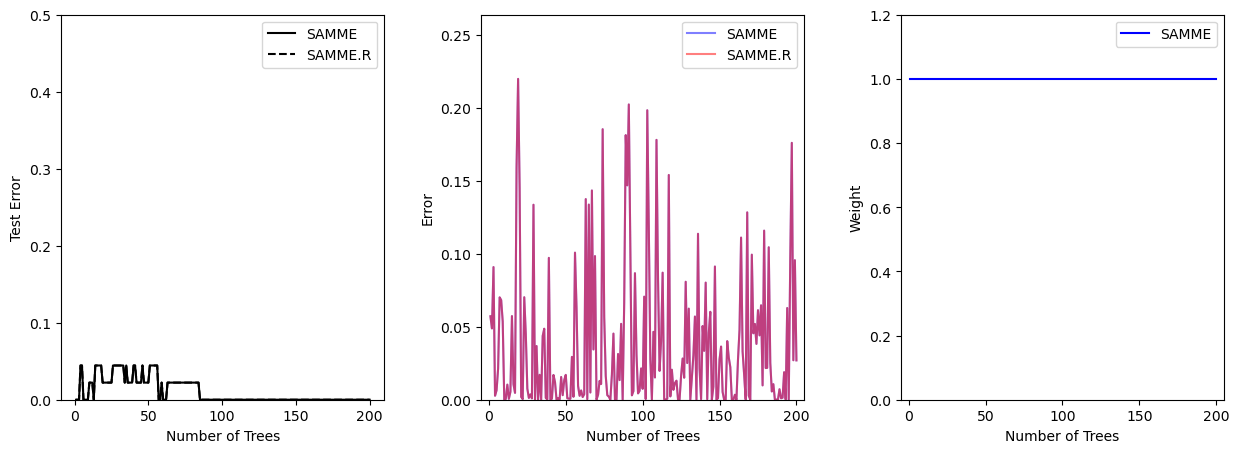

In [56]:
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 定义两个 AdaBoost 分类器：SAMME.R 和 SAMME
bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=1.0)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=1.0)

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

# 记录测试误差
real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_test_predict in zip(
        bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(1. - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(1. - accuracy_score(discrete_test_predict, y_test))

# 提取弱分类器的错误率和权重
n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

# 绘制训练过程中的误差变化图
plt.figure(figsize=(15, 5))

# 测试误差
plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1), discrete_test_errors, c='black', label='SAMME')
plt.plot(range(1, n_trees_real + 1), real_test_errors, c='black', linestyle='dashed', label='SAMME.R')
plt.legend()
plt.ylim(0.0, 0.5)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

# 每棵树的错误率
plt.subplot(132)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors, "b", label='SAMME', alpha=0.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors, "r", label='SAMME.R', alpha=0.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((0, max(real_estimator_errors.max(), discrete_estimator_errors.max()) * 1.2))
plt.xlim((-5, n_trees_discrete + 5))

# 弱分类器权重（SAMME）
plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights, "b", label='SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-5, n_trees_discrete + 5))

plt.subplots_adjust(wspace=0.3)
plt.show()

## 测试VotingClassifier的分类效果，并且自主实现
[参考资料](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)

VotingClassifier主要分成两类——**Majority Class Labels** 和 **Weighted Average Probabilities**

**Majority Class Labels算法流程**
- 在多数投票中，特定样本的预测类标签是代表每个单独分类器预测的类标签的大多数（模式）的类标签
- VotingClassifier （带有 voting='hard' ）将根据多数类别标签将样本归类为“第 1 类”。
- 如果出现平局， VotingClassifier 将根据升序选择班级

**使用Sklearn的Voting Classifier(Hard)**

代码如下所示

In [57]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.04) [Logistic Regression]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.04) [Ensemble]


**Weighted Average Probabilities算法流程**
- 可以通过 weights 参数为每​​个分类器分配特定的权重

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.metrics import accuracy_score

# Loading some example data
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1 = clf1.fit(X, y)
clf2 = clf2.fit(X, y)
clf3 = clf3.fit(X, y)
eclf = eclf.fit(X, y)

# 输出预测正确率
y_pred = eclf.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Voting Classifier(soft) 训练集准确率: {:.2f}%".format(accuracy * 100))

Voting Classifier(soft) 训练集准确率: 98.00%


**对于多数表决法进行自主实现**

仿照前面的Bagging算法可以对fit、predict两个函数进行实现

这里采用与前面相同的三种分类器（决策树、随机森林、GausssianNB）最终的预测正确率为 **97%** (sklearn的模版预测准确率为**95%**)

In [59]:
from sklearn.base import BaseEstimator,ClassifierMixin,clone
import numpy as np
from scipy.stats import mode

class MyHardVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        """
        参数 estimators: list of (name, estimator) 元组如[('dt', DecisionTreeClassifier()), ('knn', KNeighborsClassifier())]
        """
        self.estimators = estimators
        self.clfs_ = []

    def fit(self, X, y):
        self.clfs_ = []
        for name, clf in self.estimators:
            fitted_clf = clone(clf).fit(X, y)
            self.clfs_.append(fitted_clf)
        return self

    def predict(self, X):
        predictions = np.asarray([clf.predict(X) for clf in self.clfs_])
        majority_vote, _ = mode(predictions, axis=0, keepdims=False)
        return majority_vote

X, y = iris.data[:, 1:3], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = MyHardVotingClassifier([
    ('dt', DecisionTreeClassifier(max_depth=4)),
    ('rf',  RandomForestClassifier(n_estimators=50, random_state=1)),
    ('Gaussian', GaussianNB())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"自定义Hard Voting 分类器准确率: {acc:.2f}")

自定义Hard Voting 分类器准确率: 0.97


## 测试GradientBoostingClassifier的分类效果，并且自主实现

[参考资料一](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) AND 
[参考资料二](https://medium.com/data-science/all-you-need-to-know-about-gradient-boosting-algorithm-part-2-classification-d3ed8f56541e) AND 
[参考资料三](https://www.digitalocean.com/community/tutorials/gradient-boosting-for-classification)

梯度提升有三个主要组成部分：**Loss Function**、**Weak Learner**、**Additive Model**

**算法流程**

- 开始 → 初始化F(x)
- 计算残差（y - p）→ 用残差训练新模型 → 累加模型输出
- 重复直到 n_estimators 次
- 最终用 softmax(F(x)) → 得出预测类别

In [60]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9555555555555556

In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
class MyGradientBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=100, learning_rate=0.1):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeRegressor(max_depth=1)
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators_ = []
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        lb = LabelBinarizer()
        Y = lb.fit_transform(y)

        if Y.shape[1] == 1:
            Y = np.hstack((1 - Y, Y))

        self.estimators_ = [[] for _ in range(len(self.classes_))]
        F = np.zeros(Y.shape)

        for m in range(self.n_estimators):
            for k in range(len(self.classes_)):
                residual = Y[:, k] - self._sigmoid(F[:, k])
                clf = clone(self.base_estimator)
                clf.fit(X, residual)
                update = clf.predict(X)
                F[:, k] += self.learning_rate * update
                self.estimators_[k].append(clf)

        return self

    def predict(self, X):
        F = np.zeros((X.shape[0], len(self.classes_)))
        for k in range(len(self.classes_)):
            for clf in self.estimators_[k]:
                F[:, k] += self.learning_rate * clf.predict(X)
        return self.classes_[np.argmax(F, axis=1)]

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
X, y = iris.data[:, 1:3], iris.target  # 只选取两个特征

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = MyGradientBoostClassifier(
    base_estimator=DecisionTreeRegressor(max_depth=2),
    n_estimators=50,
    learning_rate=0.1
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"自定义Gradient Boost 分类器准确率: {acc:.2f}")

自定义Gradient Boost 分类器准确率: 0.97


## 将三种分类算法替换为相应的回归算法，并且与SKlearn做比较
这里采用sklearn提供的糖尿病数据集进行回归拟合，测试三种算法的R2
$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$
### Stacking Regression版本
- sklearn提供的stacking回归算法的拟合结果为 **0.53**
- 自主实现的stacking回归算法的拟合结果为 **0.54** 拟合效果稍微好一点

In [62]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score

estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('knr', KNeighborsRegressor(n_neighbors=20,metric='euclidean'))]
final_estimator = GradientBoostingRegressor(
    n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
    random_state=42)
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator)

from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('R2 score(sklearn): {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score(sklearn): 0.53


In [63]:
class MyStackingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, final_estimator):
        self.estimators = estimators
        self.final_estimator = final_estimator

    def fit(self, X, y):
        self.base_models_ = [clone(est) for _, est in self.estimators]
        self.final_model_ = clone(self.final_estimator)

        base_preds = []
        for model in self.base_models_:
            model.fit(X, y)
            pred = model.predict(X).reshape(-1, 1)
            base_preds.append(pred)

        meta_X = np.hstack(base_preds)
        self.final_model_.fit(meta_X, y)
        return self

    def predict(self, X):
        base_preds = [model.predict(X).reshape(-1, 1) for model in self.base_models_]
        meta_X = np.hstack(base_preds)
        return self.final_model_.predict(meta_X)
    
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean'))]

final_estimator = GradientBoostingRegressor(
    n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
    random_state=42)

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

reg = MyStackingRegressor(estimators=estimators, final_estimator=final_estimator)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('R2 score(MyStacking): {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score(MyStacking): 0.54


### Bagging Regression
- sklearn提供的Bagging回归算法的拟合结果为 **0.49**
- 自主实现的Bagging回归算法的拟合结果为 **0.49** 拟合效果稍微好一点

In [64]:
from sklearn.ensemble import BaggingRegressor

X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

reg = BaggingRegressor(
    estimator=RidgeCV(),
    n_estimators=10,
    bootstrap=True,
    random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('R2 score(sklearn Bagging): {:.2f}'.format(r2_score(y_test, y_pred)))

class MyBaggingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, n_estimators=10, bootstrap=True, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.random_state = random_state

    def fit(self, X, y):
        self.models_ = []
        rng = np.random.RandomState(self.random_state)

        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            model = clone(self.base_estimator)
            if self.bootstrap:
                indices = rng.choice(n_samples, n_samples, replace=True)
            else:
                indices = np.arange(n_samples)

            X_sample = X[indices]
            y_sample = y[indices]
            model.fit(X_sample, y_sample)
            self.models_.append(model)

        return self

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=0)
    
reg = MyBaggingRegressor(
    base_estimator=RidgeCV(),
    n_estimators=10,
    bootstrap=True,
    random_state=42)
reg.fit(X_train, y_train)
y_pred_2 = reg.predict(X_test)

print('R2 score(custom Bagging): {:.2f}'.format(r2_score(y_test, y_pred_2)))

R2 score(sklearn Bagging): 0.49
R2 score(custom Bagging): 0.49


### AdaBoosting Regression
- sklearn提供的AdaBoosting回归算法的拟合结果为 **0.46**
- 自主实现的AdaBoosting回归算法的拟合结果为 **0.46** 拟合效果稍微好一点

In [65]:
from sklearn.ensemble import AdaBoostRegressor

reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=50,
    learning_rate=0.5,
    random_state=42
)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('R2 score(sklearn AdaBoost): {:.2f}'.format(r2_score(y_test, y_pred)))

class MyAdaBoostRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, n_estimators=50, learning_rate=1.0, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state

    def fit(self, X, y):
        self.models_ = []
        self.model_weights_ = []

        n_samples = X.shape[0]
        rng = np.random.RandomState(self.random_state)

        sample_weights = np.ones(n_samples) / n_samples

        for i in range(self.n_estimators):
            model = clone(self.base_estimator)
            model.fit(X, y, sample_weight=sample_weights)

            y_pred = model.predict(X)
            error = np.average((y - y_pred) ** 2, weights=sample_weights)

            error = max(error, 1e-10)
            if error >= 0.5:
                continue
            model_weight = self.learning_rate * 0.5 * np.log((1 - error) / error)
            self.models_.append(model)
            self.model_weights_.append(model_weight)

            sample_weights *= np.exp(model_weight * np.abs(y - y_pred))
            sample_weights /= np.sum(sample_weights)

        return self

    def predict(self, X):
        final_pred = np.zeros(X.shape[0])
        total_weight = np.sum(self.model_weights_)
        for model, weight in zip(self.models_, self.model_weights_):
            final_pred += weight * model.predict(X)
        return final_pred / total_weight if total_weight != 0 else final_pred

reg_2 = MyAdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=50,
    learning_rate=0.5,
    random_state=42
)
reg_2.fit(X_train, y_train)
y_pred_2 = reg.predict(X_test)

print('R2 score(custom AdaBoost): {:.2f}'.format(r2_score(y_test, y_pred_2)))

R2 score(sklearn AdaBoost): 0.46
R2 score(custom AdaBoost): 0.46
